# 11. Arrests / Los Angeles demographics -- using folium

This notebook will perform an EDA over the Department 49-00033 (Los Angeles, CA) arrests and demographics.

A hope is that this will provide some insights and experience into plotting tools, e.g. folium and holoviews, and that it may also give some insights into the data and how it should be wrangled. Hope for the best (:

# Results

*there are also some usual plots in the end*

folium is a good library (great, actually), but, I don't feel it is suited for this problem. There is pretty good integration with leaflet and lots of utils and it would suffice on making vanilla (interactive) maps.

Interactive might be good, giving one example, if there's a map of districts and one police officer wants to click on one department to know its statistics regarding policing equity.

This, however, is not the usual flow of CPE and it would something somehow complex to add to their flow. Their flow looks like receiving data from a police department, processing/modelling from it and then generating a *hand-tailored* report containing results and recommendations! An interactive map doesn't fit much in there.

However, I will keep it in mind when the *data asks for it* or when *presenting in a particular platform* (e.g. Kaggle kernels). The tool may present good use :)

# Load data

In [1]:
import folium
import folium.plugins
import geopandas
import matplotlib.pyplot
import pandas
import shapely

from cpe_help import Department, util

In [2]:
dept = Department('49-00033')
dept

Department('49-00033')

## Arrests

In [3]:
!ls {dept.external_dir}

49-00033_Arrests_2015.csv  shapefiles


In [4]:
raw_arrests = pandas.read_csv(dept.external_dir / '49-00033_Arrests_2015.csv', low_memory=False)
raw_arrests.head()

,INCIDENT_DATE,INCIDENT_TIME,INCIDENT_UNIQUE_IDENTIFIER,LOCATION_DISTRICT,LOCATION_TYPE,UNKNOWN_FIELD_TYPE,SUBJECT_AGE,SUBJECT_GENDER,SUBJECT_RACE,UNKNOWN_FIELD_TYPE.1,INCIDENT_REASON,UNKNOWN_FIELD_TYPE.2,CHARGE,CHARGE_DESCRIPTION,LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION,CROSS_STREET,LOCATION_LATITUDE,LOCATION_LONGITUDE
0,ARST DATE,TIME,RPT_ID,AREA,AREA_DESC,RD,AGE,SEX_CD,DESCENT_CD,CHRG_GRP_CD,GRP_DESC,ARST_TYP_CD,CHARGE,CHRG_DESC,LOCATION,CRSST,Location Lat,Location Lon
1,12/31/15 0:00,2345,4538991,14,Pacific,1435,43,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,3500 MCLAUGHLIN AV,NaN,34.0141,-118.4288
2,12/31/15 0:00,2330,4538996,1,Central,101,27,M,W,4,Aggravated Assault,F,273.5(A)PC,CORPORAL INJURY ON SPOUSE/COHABITANT/ETC,900 FIGUEROA TR,NaN,34.0663,-118.2441
3,12/31/15 0:00,2320,4539142,6,Hollywood,646,31,M,W,16,Narcotic Drug Laws,M,11350(A)HS,POSSESSION OF CONTROLLED SUBSTANCE,6300 HOLLYWOOD BL,NaN,34.1016,-118.3267
4,12/31/15 0:00,2319,4538947,21,Topanga,2189,28,M,H,22,Driving Under Influence,M,23152(A)VC,DRUNK DRIVING ALCOHOL/DRUGS,VENTURA FY,WINNETKA,34.1723,-118.5709


## Block groups + precincts

In [5]:
bgs = dept.load_block_groups()
precincts = dept.load_police_precincts()
precincts.head()

,slug,set,kind,external_i,name,display_na,url,number,phone_numb,address,square_mil,Total Population,geometry
0,77th-street-lapd-division,LAPD Divisions,LAPD Division,12,77th Street,77th Street LAPD Division,http://www.lapdonline.org/77th_street_communit...,12,213-485-4164,7600 S. Broadway,11.3334694611,179296.839176,POLYGON ((-118.3148948951553 34.00371678060566...
1,central-lapd-division,LAPD Divisions,LAPD Division,1,Central,Central LAPD Division,http://www.lapdonline.org/central_community_po...,1,213-485-3294,251 E. 6th St.,4.9051505769,62590.759758,POLYGON ((-118.2243816590658 34.06850962588265...
2,devonshire-lapd-division,LAPD Divisions,LAPD Division,17,Devonshire,Devonshire LAPD Division,http://www.lapdonline.org/devonshire_community...,17,818-832-0633,10250 Etiwanda Ave.,48.310389692,228374.549545,POLYGON ((-118.4896378723103 34.31514263477411...
3,foothill-lapd-division,LAPD Divisions,LAPD Division,16,Foothill,Foothill LAPD Division,http://www.lapdonline.org/foothill_community_p...,16,818-756-8861,12760 Osborne St.,46.5372672192,192480.979939,POLYGON ((-118.3829144583267 34.29425373977321...
4,harbor-lapd-division,LAPD Divisions,LAPD Division,5,Harbor,Harbor LAPD Division,http://www.lapdonline.org/harbor_community_pol...,5,310-726-7700,2175 John S. Gibson Blvd.,32.0275914881,181954.411287,POLYGON ((-118.2815067203804 33.86634772230949...


# Preprocess

In [6]:
raw_arrests.shape

(126855, 18)

In [7]:
'{:.2%}'.format(
    (raw_arrests['LOCATION_LATITUDE'] == '0').mean())

'5.32%'

In [8]:
raw_arrests.head().T

,0,1,2,3,4
INCIDENT_DATE,ARST DATE,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00,12/31/15 0:00
INCIDENT_TIME,TIME,2345,2330,2320,2319
INCIDENT_UNIQUE_IDENTIFIER,RPT_ID,4538991,4538996,4539142,4538947
LOCATION_DISTRICT,AREA,14,1,6,21
LOCATION_TYPE,AREA_DESC,Pacific,Central,Hollywood,Topanga
UNKNOWN_FIELD_TYPE,RD,1435,101,646,2189
SUBJECT_AGE,AGE,43,27,31,28
SUBJECT_GENDER,SEX_CD,M,M,M,M
SUBJECT_RACE,DESCENT_CD,H,W,W,H
UNKNOWN_FIELD_TYPE.1,CHRG_GRP_CD,22,4,16,22


In [9]:
variables = pandas.Series(raw_arrests.columns, index=raw_arrests.loc[0])
arrests = raw_arrests.loc[1:].copy()

# process date and drop time
arrests['INCIDENT_DATE'] = pandas.to_datetime(
    arrests['INCIDENT_DATE'], format='%m/%d/%y %H:%M')
arrests = arrests.drop('INCIDENT_TIME', axis=1)

# convert dtypes
numeric_columns = [
    'LOCATION_LATITUDE',
    'LOCATION_LONGITUDE',
]
arrests[numeric_columns] = arrests[numeric_columns].apply(pandas.to_numeric)

# drop entries where lat/lon is unknown
# (5.32% of the entries)
# (could have retrieved approximate lat/lon from address)
arrests = arrests[
    (arrests['LOCATION_LATITUDE'] != 0) &
    (arrests['LOCATION_LONGITUDE'] != 0)
]

# generate points from location
points = [shapely.geometry.Point(x, y)
          for x, y in zip(
              arrests['LOCATION_LONGITUDE'], arrests['LOCATION_LATITUDE'])]

# convert to GeoDataFrame
arrests = geopandas.GeoDataFrame(
    arrests,
    geometry=points,
    crs=util.crs.epsg4326,
)


# Check preprocessed

Only 2015 data:

In [10]:
arrests['INCIDENT_DATE'].min()

Timestamp('2015-01-01 00:00:00')

In [11]:
arrests['INCIDENT_DATE'].max()

Timestamp('2015-12-31 00:00:00')

In [12]:
arrests.crs

{'init': 'epsg:4326', 'no_defs': True}

In [13]:
arrests.isnull().mean()

INCIDENT_DATE                                   0.000000
INCIDENT_UNIQUE_IDENTIFIER                      0.000000
LOCATION_DISTRICT                               0.000000
LOCATION_TYPE                                   0.000000
UNKNOWN_FIELD_TYPE                              0.000000
SUBJECT_AGE                                     0.000000
SUBJECT_GENDER                                  0.000000
SUBJECT_RACE                                    0.000000
UNKNOWN_FIELD_TYPE.1                            0.105606
INCIDENT_REASON                                 0.105964
UNKNOWN_FIELD_TYPE.2                            0.000000
CHARGE                                          0.000000
CHARGE_DESCRIPTION                              0.089986
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION    0.000000
CROSS_STREET                                    0.432722
LOCATION_LATITUDE                               0.000000
LOCATION_LONGITUDE                              0.000000
geometry                       

In [14]:
arrests.drop('geometry', axis=1).apply(lambda x: x.nunique()).sort_values()

SUBJECT_GENDER                                       2
UNKNOWN_FIELD_TYPE.2                                 5
SUBJECT_RACE                                        16
LOCATION_DISTRICT                                   21
LOCATION_TYPE                                       21
INCIDENT_REASON                                     27
UNKNOWN_FIELD_TYPE.1                                28
SUBJECT_AGE                                         92
INCIDENT_DATE                                      365
CHARGE_DESCRIPTION                                1164
UNKNOWN_FIELD_TYPE                                1239
CHARGE                                            2225
LOCATION_LONGITUDE                                4038
LOCATION_LATITUDE                                 4183
CROSS_STREET                                      5148
LOCATION_FULL_STREET_ADDRESS_OR_INTERSECTION     21461
INCIDENT_UNIQUE_IDENTIFIER                      120107
dtype: int64

In [15]:
# scatter

minx, miny, maxx, maxy = arrests.total_bounds
midx = (minx + maxx) / 2
midy = (miny + maxy) / 2
map = folium.Map(
    location=(34.05, -118.25),
    tiles='cartodbpositron',
    zoom_start=8,
    min_zoom=8,
    max_zoom=14,
)

for _, row in arrests.sample(500).iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    
    arr_type = {
        'D': 'Dependent',
        'F': 'Felony',
        'I': 'Infraction',
        'M': 'Misdemeanor',
        'O': 'Other',
    }[row['UNKNOWN_FIELD_TYPE.2']]
    color = {
        'F': '#e41a1c',
        'D': '#377eb8',
        'M': '#4daf4a',
        'I': '#984ea3',
        'O': '#ff7f00',
    }[row['UNKNOWN_FIELD_TYPE.2']]
    
    folium.CircleMarker(
        location=(lat, lon),
        fill=True,
        color=color,
        popup=arr_type,
        radius=5,
    ).add_to(map)

map

Folium is good, but, we want to render to pdf in the end. Folium is not good in this :(

# Visualization

## Total Population

In [37]:
# only use intersecting BGs
bgs = bgs[bgs.intersects(precincts.unary_union)]

# set up equal-area projection
proj = util.crs.equal_area_from_geodf(bgs)
bgs = bgs.to_crs(proj)
precincts = precincts.to_crs(proj)

In [38]:
# calculate density
bgs['Population Density'] = bgs['Total Population'] / (bgs.area / 10 ** 6)

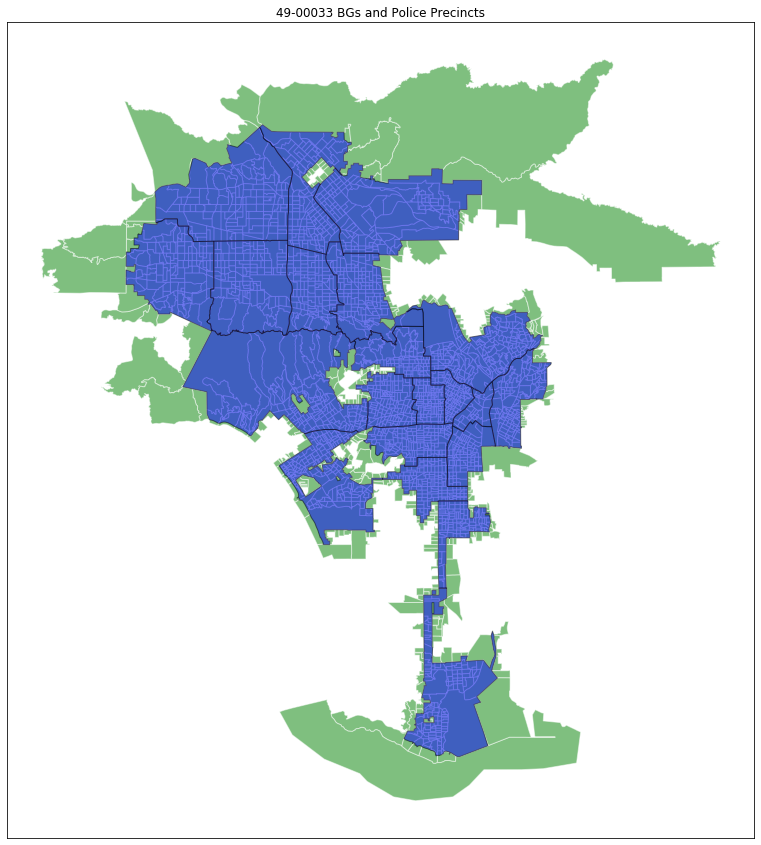

In [39]:
fig, ax = matplotlib.pyplot.subplots(figsize=(15, 15))

bgs.plot(ax=ax, color='green', edgecolor='white', alpha=0.5)
precincts.plot(ax=ax, color='blue', edgecolor='black', alpha=0.5)

ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('{} BGs and Police Precincts'.format(dept.name));

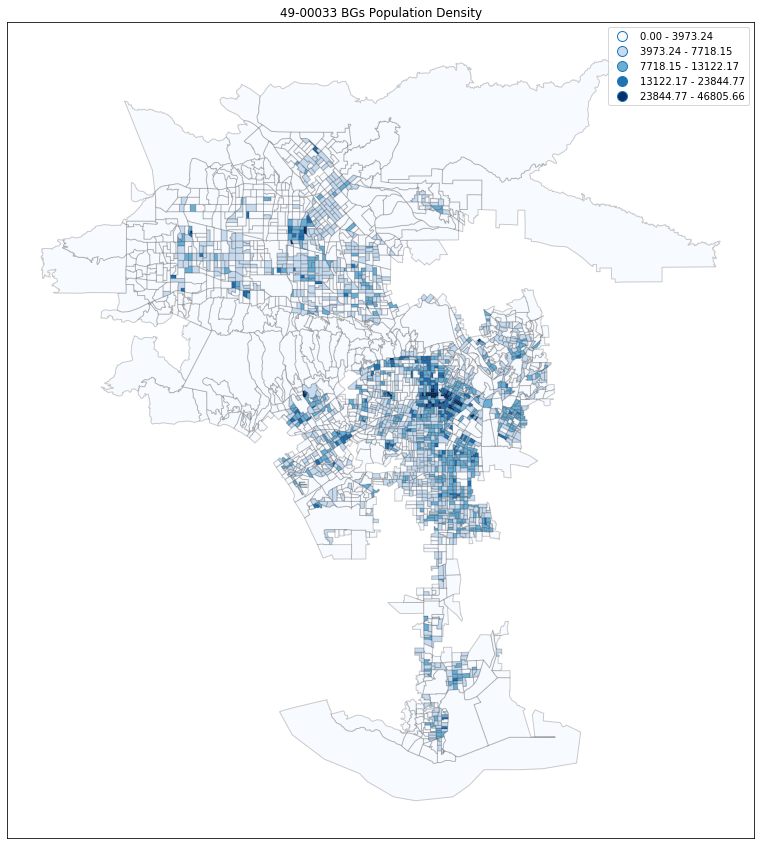

In [43]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20, 15))

bgs.plot(
    ax=ax,
    column='Population Density',
    cmap='Blues',
    edgecolor=(0, 0, 0, 0.2),
    scheme='fisher_jenks',
    k=5,
    legend=True,
)

ax.set_aspect('equal')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_title('{} BGs Population Density (/km^2)'.format(dept.name));